In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

In [2]:
df16 = pd.read_pickle("data/survey2016_final.pkl")
df17 = pd.read_pickle("data/survey2017_final.pkl")
df17 = df17[[isinstance(x, str) for x in df17.Country]]
df18 = pd.read_pickle("data/survey2018_final.pkl")
df19 = pd.read_pickle("data/survey2019_final.pkl")
survey_data = pd.concat([df16, df17, df18, df19], sort=True, ignore_index=True)

In [3]:
survey_data.head()

,Age,ConvertedSalary,Country,Gender,Hobby,JobSatisfaction,LanguageDesireNextYear,LanguageWorkedWith,StackOverflowParticipate,StackOverflowVisit,Year,YearsCoding
0,30-34,45000.0,AFG,Male,Yes,7.0,[Swift],"[iOS, Objective-C]",NA,Multiple times per day,2016,6 - 10 years
1,0,5000.0,AFG,Female,Yes,7.0,[],[],NA,A few times per week,2016,11+ years
2,0,210000.0,AFG,Prefer not to disclose,No,-1.0,[Android],"[Android, Arduino / Raspberry Pi, AngularJS,...",NA,Multiple times per day,2016,11+ years
3,25-29,5000.0,AFG,Male,No,7.0,"[Android, iOS]","[JavaScript, PHP, SQL, WordPress]",NA,A few times per week,2016,0 - 2 years
4,20-24,5000.0,ALB,Male,Yes,5.5,"[Android, iOS, Java, JavaScript, Node.js, ...",[PHP],NA,Multiple times per day,2016,0 - 2 years


In [4]:
mappings = {"HTML":"HTML/CSS", "CSS":"HTML/CSS", "Bash/Shell":"Bash/Shell/PowerShell"}
def cleanLanguage(lang):
    res = lang.strip()
    if res in mappings:
        res = mappings[res]
    return res
survey_data.LanguageWorkedWith = survey_data.LanguageWorkedWith.apply(lambda langs: list({cleanLanguage(lang) for lang in langs}))

In [5]:
languages = list(survey_data.explode("LanguageWorkedWith").LanguageWorkedWith.unique())
exploded = survey_data.explode("LanguageWorkedWith")
exploded.LanguageWorkedWith.fillna("Nothing", inplace=True)

In [6]:
exploded.LanguageWorkedWith = exploded.LanguageWorkedWith.apply(lambda l: l.strip())

In [28]:
langs = exploded[["LanguageWorkedWith"]]
langs["dummy"] = True

/home/severi/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
pivoted = langs.pivot(columns="LanguageWorkedWith")["dummy"]
pivoted.index.rename("", inplace=True)
pivoted.fillna(False, inplace=True)

In [30]:
pivoted.head()

LanguageWorkedWith,Android,AngularJS,Arduino / Raspberry Pi,Assembly,Bash/Shell/PowerShell,C,C#,C++,Cassandra,Clojure,...,Swift,TypeScript,VB.NET,VBA,Visual Basic,Visual Basic 6,WebAssembly,Windows Phone,WordPress,iOS
,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,False,False,True,True,True,True,True,...,True,False,False,False,True,False,False,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
list(pivoted.columns)

['Android',
 'AngularJS',
 'Arduino / Raspberry Pi',
 'Assembly',
 'Bash/Shell/PowerShell',
 'C',
 'C#',
 'C++',
 'Cassandra',
 'Clojure',
 'Cloud (AWS, GAE, Azure, etc.)',
 'Cobol',
 'CoffeeScript',
 'Common Lisp',
 'Cordova',
 'Dart',
 'Delphi/Object Pascal',
 'Elixir',
 'Erlang',
 'F#',
 'Go',
 'Groovy',
 'HTML/CSS',
 'Hack',
 'Hadoop',
 'Haskell',
 'Java',
 'JavaScript',
 'Julia',
 'Kotlin',
 'LAMP',
 'Lua',
 'Matlab',
 'MongoDB',
 'Node.js',
 'Nothing',
 'Objective-C',
 'Ocaml',
 'Other(s):',
 'PHP',
 'Perl',
 'Python',
 'R',
 'ReactJS',
 'Redis',
 'Ruby',
 'Rust',
 'SQL',
 'SQL Server',
 'Salesforce',
 'Scala',
 'SharePoint',
 'Smalltalk',
 'Spark',
 'Swift',
 'TypeScript',
 'VB.NET',
 'VBA',
 'Visual Basic',
 'Visual Basic 6',
 'WebAssembly',
 'Windows Phone',
 'WordPress',
 'iOS']

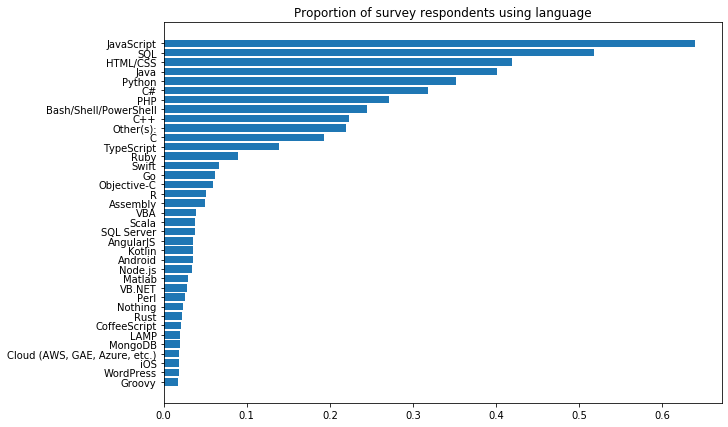

In [32]:
"""Distribution of programming languages"""
prog_lang_distr = pivoted.sum()
prog_lang_distr["Other(s):"] += prog_lang_distr[prog_lang_distr < 4000].sum()
prog_lang_distr.drop(prog_lang_distr[prog_lang_distr < 4000].index, inplace=True)
prog_lang_distr.sort_values(inplace=True)
prog_lang_distr = prog_lang_distr / len(pivoted)
plt.figure(figsize=(10,7))
plt.barh(prog_lang_distr.index, prog_lang_distr)
plt.title("Proportion of survey respondents using language")
plt.savefig("figures/language_distribution.png", bbox_inches="tight")

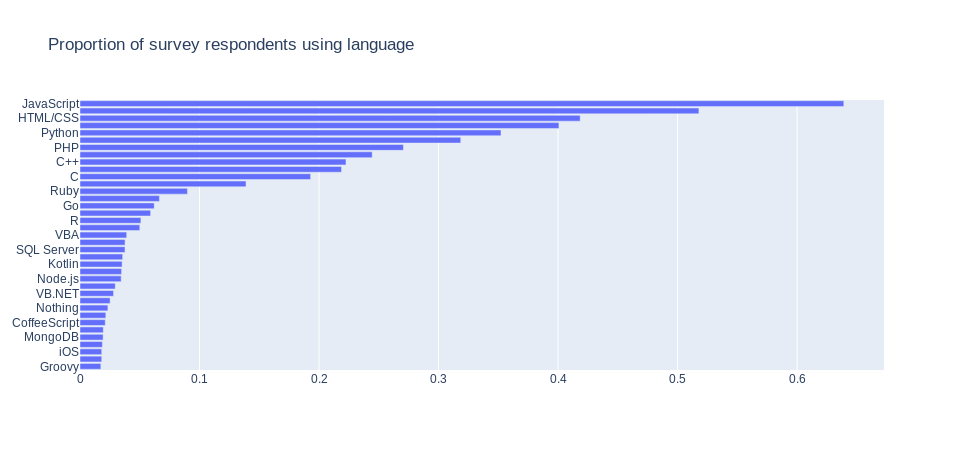

'figures/language_distribution.html'

In [108]:
fig = go.Figure()
fig.add_trace(go.Bar(
        y=prog_lang_distr.index,
        x=prog_lang_distr,
        orientation='h'
    ))
fig.update_layout(
    title_text = "Proportion of survey respondents using language"
)
fig.show()
plotly.offline.plot(fig, filename="figures/language_distribution.html", auto_open=False, include_plotlyjs=True)

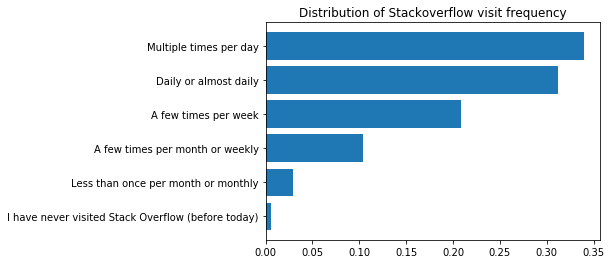

In [33]:
"""Distribution of visit frequency"""
visit_frequency = survey_data.groupby("StackOverflowVisit").count().Age.drop("NA")
visit_ordering = ["I have never visited Stack Overflow (before today)", "Less than once per month or monthly", 
                  "A few times per month or weekly", "A few times per week", "Daily or almost daily",
                 "Multiple times per day"]
visit_frequency = visit_frequency[visit_ordering]
visit_frequency = visit_frequency / sum(visit_frequency)
fig = plt.figure()
plt.plot()
plt.barh(visit_frequency.index, visit_frequency)
plt.title("Distribution of Stackoverflow visit frequency")
plt.savefig("figures/visit_frequency_distr.png", bbox_inches="tight")

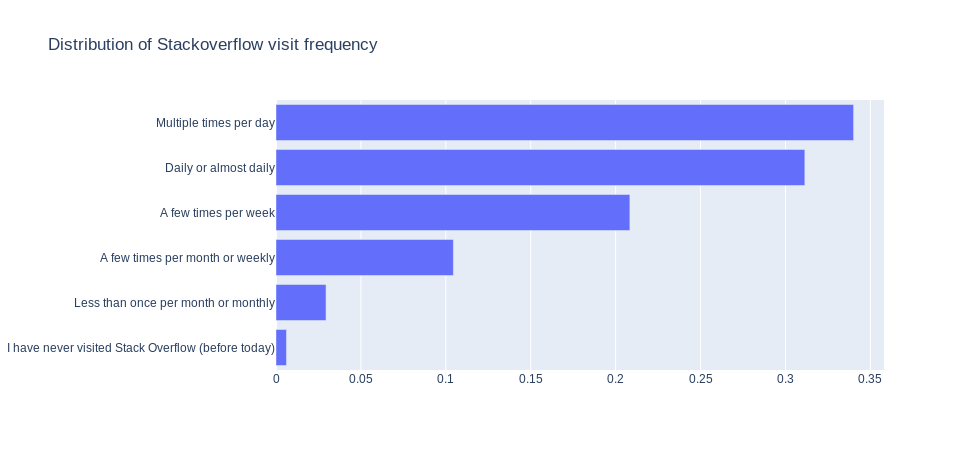

'figures/visit_frequency.html'

In [107]:
fig = go.Figure()
fig.add_trace(go.Bar(
        y=visit_frequency.index,
        x=visit_frequency,
        orientation='h'
    ))
fig.update_layout(
    title_text = "Distribution of Stackoverflow visit frequency"
)
fig.show()
plotly.offline.plot(fig, filename="figures/visit_frequency.html", auto_open=False, include_plotlyjs=True)

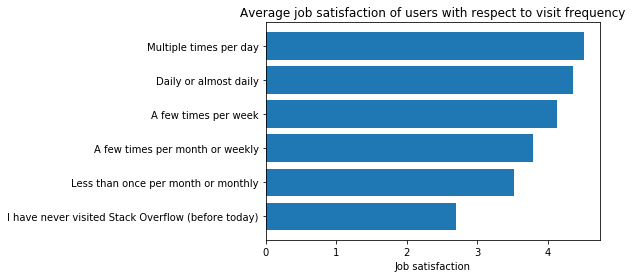

In [34]:
"""Job satisfaction with respect to visit frequency"""
job_satisfaction = survey_data.groupby("StackOverflowVisit").mean().JobSatisfaction.drop("NA")
job_satisfaction = job_satisfaction[visit_ordering]
plt.figure()
plt.barh(job_satisfaction.index, job_satisfaction)
plt.xlabel("Job satisfaction")
plt.title("Average job satisfaction of users with respect to visit frequency")
plt.savefig("figures/visit_freq_job_satisfaction.png", bbox_inches="tight")

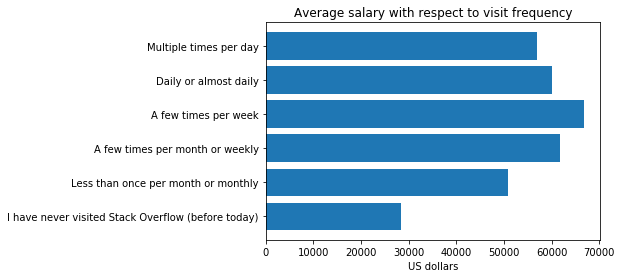

In [35]:
"""Average salary with respect to visit frequency"""
avg_salary = survey_data.groupby("StackOverflowVisit").mean().ConvertedSalary.drop("NA")
avg_salary = avg_salary[visit_ordering]
plt.figure()
plt.barh(avg_salary.index, avg_salary)
plt.xlabel("US dollars")
plt.title("Average salary with respect to visit frequency")
plt.savefig("figures/visit_freq_salary.png", bbox_inches="tight")

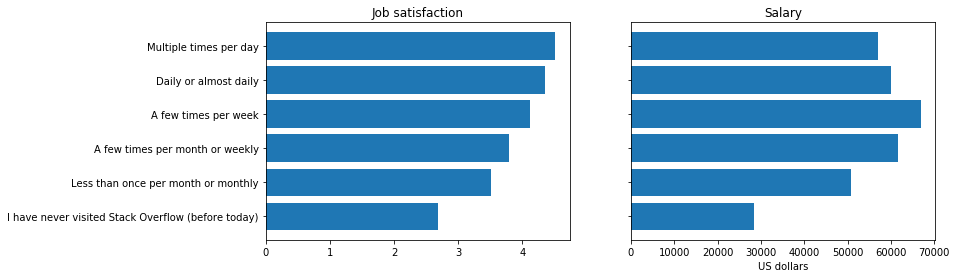

In [36]:
"""The above two plots in a subplot structure"""
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,4))
axes[0].barh(job_satisfaction.index, job_satisfaction)
axes[0].set_title("Job satisfaction")
axes[1].barh(avg_salary.index, avg_salary)
axes[1].set_title("Salary")
axes[1].set_xlabel("US dollars")
plt.savefig("figures/visit_freq_job_satisfaction_and_salary.png", bbox_inches="tight")

In [106]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    #specs=[[{"type": "bar"}, {"type": "bar"}]],
    subplot_titles=("Job satisfaction", "Salary"),
    shared_yaxes=True
)

fig.add_trace(go.Bar(
        y=job_satisfaction.index,
        x=job_satisfaction,
        orientation='h'
    ),
    row=1, col=1
)

fig.add_trace(go.Bar(
        y=avg_salary.index,
        x=avg_salary,
        orientation='h',
    ),
    row=1, col=2
)

fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="US dollars", row=1, col=2)
plotly.offline.plot(fig, filename="figures/job_satisfaction_salary.html", auto_open=False, include_plotlyjs=True)

'figures/job_satisfaction_salary.html'

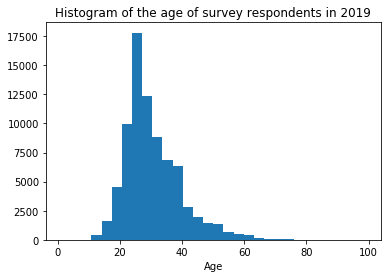

In [19]:
"""Age distribution (for 2019)"""
ages = df19.Age[df19.Age > 0]
ages = ages
plt.figure()
plt.hist(ages, bins=30)
plt.title("Histogram of the age of survey respondents in 2019")
plt.xlabel("Age")
plt.savefig("figures/age_distribution.png")

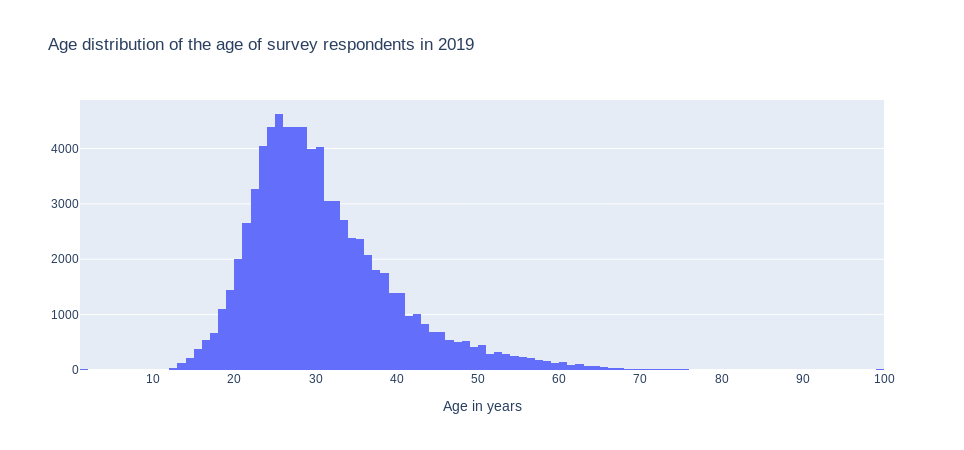

'figures/age_distribution.html'

In [105]:
fig = go.Figure(data=[go.Histogram(x=ages, xbins=dict( # bins used for histogram
        start=0,
        end=100.0,
        size=1
    ))])
fig.update_layout(
    title_text = 'Age distribution of the age of survey respondents in 2019',
    xaxis_title="Age in years"
)
fig.show()
plotly.offline.plot(fig, filename="figures/age_distribution.html", auto_open=False, include_plotlyjs=True)

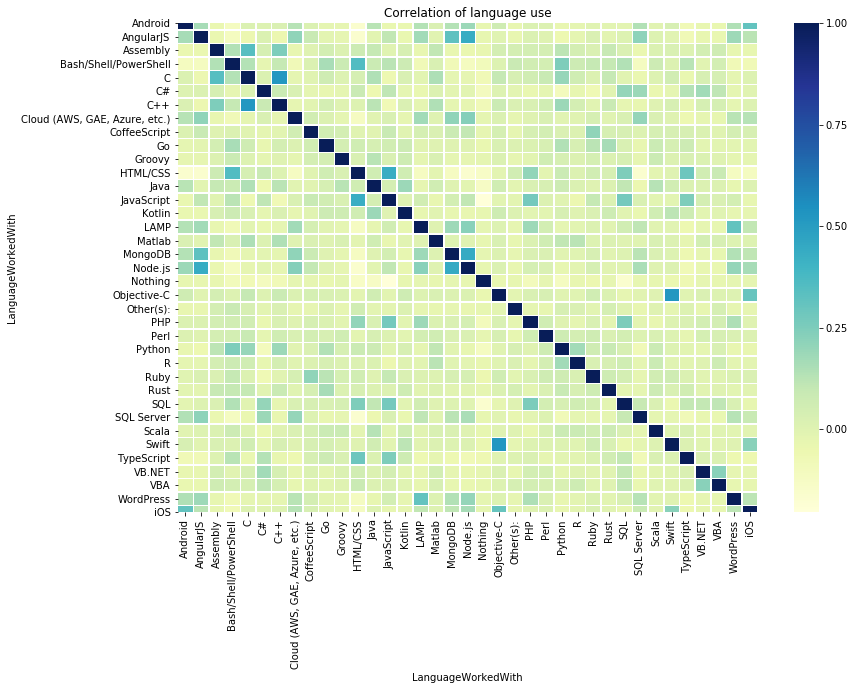

In [67]:
import seaborn as sns
common_langs = list(pivoted.sum()[pivoted.sum() > 4000].index)
plt.figure(figsize=(13,9))
ax = sns.heatmap(pivoted[common_langs].corr(), linewidth=0.5, cmap="YlGnBu")
plt.title("Correlation of language use")
plt.show()
ax.get_figure().savefig("figures/lang_correlation.png")

In [68]:
nmf_model = NMF(6)
W = nmf_model.fit_transform(pivoted)

In [96]:
types = pd.DataFrame(nmf_model.components_, columns=pivoted.columns).T
usertypes = pd.DataFrame(W)
usertypes = survey_data[["Country"]].merge(usertypes, left_index=True, right_index=True)
type_by_country = usertypes.groupby("Country").mean()#.apply(lambda row: row/row.sum(), axis=1)

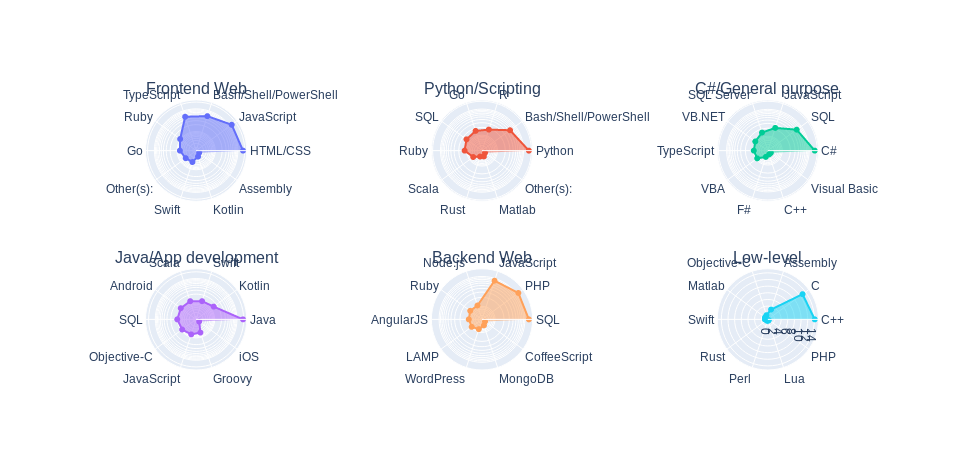

'figures/programmer_types.html'

In [104]:
"""Plot the most significant programming languages for each user group"""

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=3)
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{"type": "polar"}, {"type": "polar"}, {"type": "polar"}],
           [{"type": "polar"}, {"type": "polar"}, {"type": "polar"}]],
    subplot_titles=("Frontend Web", "Python/Scripting", "C#/General purpose", "Java/App development", "Backend Web", "Low-level")
)


for i in range(6):
    for_polar = types[i].nlargest(10)
    x = (i % 3 + 1)
    y = (int(i / 3) + 1)
    fig.add_trace(
        go.Scatterpolar(
            r=for_polar,
            theta=list(for_polar.index),
            fill='toself',
            mode="lines+markers+text",
            subplot="polar2"
        ),
        row=y, col=x
    )

#Apparently these can be formatted by 
subaxes = ["polar{}".format(i) if i != 0 else "polar" for i in range(6)]
fig.update_layout(
    {subax: dict(
        radialaxis=dict(
            visible=True,
            type="log",
            showticklabels=False
        ),
    ) for subax in subaxes}
)

fig.update_layout(
    showlegend=False
)

fig.show()
import plotly
#plotly.offline.plot(fig, filename='file.html')
#programming_types_plot = plotly.offline.plot(fig, include_plotlyjs=False, output_type='div')
plotly.offline.plot(fig, filename="figures/programmer_types.html", include_plotlyjs=True, auto_open=False)

In [72]:
"""Get dataset combining iso3-codes to country names in English"""
temp = pd.read_csv("data/IP2LOCATION-COUNTRY-MULTILINGUAL/IP2LOCATION-COUNTRY-MULTILINGUAL.CSV", 
                usecols=["LANG_NAME", "COUNTRY_ALPHA3_CODE", "COUNTRY_NAME"])
iso_to_name_df = temp[temp["LANG_NAME"] == "ENGLISH"]
iso_to_name_df = iso_to_name_df.drop("LANG_NAME", axis=1)\
    .rename({"COUNTRY_ALPHA3_CODE" : "iso3", "COUNTRY_NAME" : "country_name"}, axis=1)
iso_to_name_df.head()

,iso3,country_name
3735,AND,Andorra
3736,ARE,United Arab Emirates
3737,AFG,Afghanistan
3738,ATG,Antigua and Barbuda
3739,AIA,Anguilla


In [98]:
"""merge with type by country"""
type_by_country["isotemp"] = type_by_country.index.copy()
type_by_country = type_by_country.merge(iso_to_name_df, left_on="isotemp", right_on="iso3", how="left")
type_by_country.index = survey_data.groupby("Country").count().Age.index

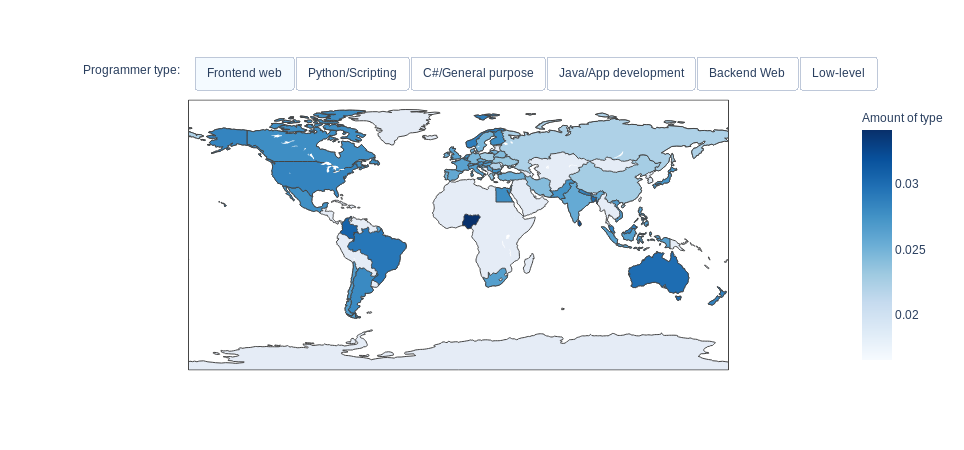

'figures/programmer_types_distribution.html'

In [103]:
"""Plot the country scores for each programmer type"""
import plotly.graph_objects as go

fig = go.Figure()

for i in range(6):
    fig.add_trace(go.Choropleth(
        locations=type_by_country.iso3[survey_data.groupby("Country").count().Age > 500], # Spatial coordinates
        z = type_by_country[survey_data.groupby("Country").count().Age > 500][i], # Data to be color-coded
        colorscale = 'Blues',
        colorbar_title = "Amount of type",
        name="2",
        visible=(i==0),
        text=type_by_country.country_name[survey_data.groupby("Country").count().Age > 500]
    ))

#fig.update_layout(
#    title_text = 'Amount of type'
#)

# Add dropdown
prog_labels = ["Frontend web", "Python/Scripting", "C#/General purpose", "Java/App development", "Backend Web", "Low-level"]
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type = "buttons",
            direction = "left",
            buttons=list([dict(
                    args=[{"visible" : [j==i for j in range(6)]}],
                    label=prog_labels[i],
                    method="update"
                ) for i in range(6) ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.15,
            xanchor="left",
            y=1.2,
            yanchor="top"
        ),
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        go.layout.Annotation(text="Programmer type:", showarrow=False,
                             x=0, y=1.15, yref="paper", align="left")
    ]
)

fig.show()
#programming_types_distribution_plot = plotly.offline.plot(fig, include_plotlyjs=False, output_type='div')
plotly.offline.plot(fig, filename="figures/programmer_types_distribution.html", include_plotlyjs=True, auto_open=False)

In [7]:
questions_df = pd.read_csv('data/stackoverflow_questions_2016-2019_notext.csv')

In [8]:
import datetime

In [9]:
questions_df.creation_date = questions_df.creation_date.apply(lambda x: datetime.datetime.strptime(x[:10], '%Y-%m-%d'))

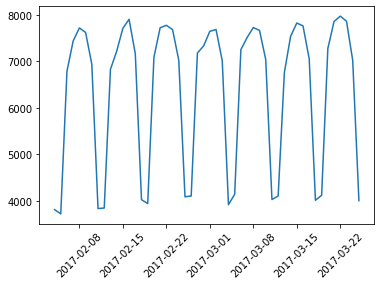

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
counts_per_day = questions_df.groupby("creation_date").count().Id
plt.figure()
plt.plot(counts_per_day[400:450].index, counts_per_day[400:450])
plt.xticks(rotation=45)
plt.savefig("figures/questions_time.png", bbox_inches="tight")

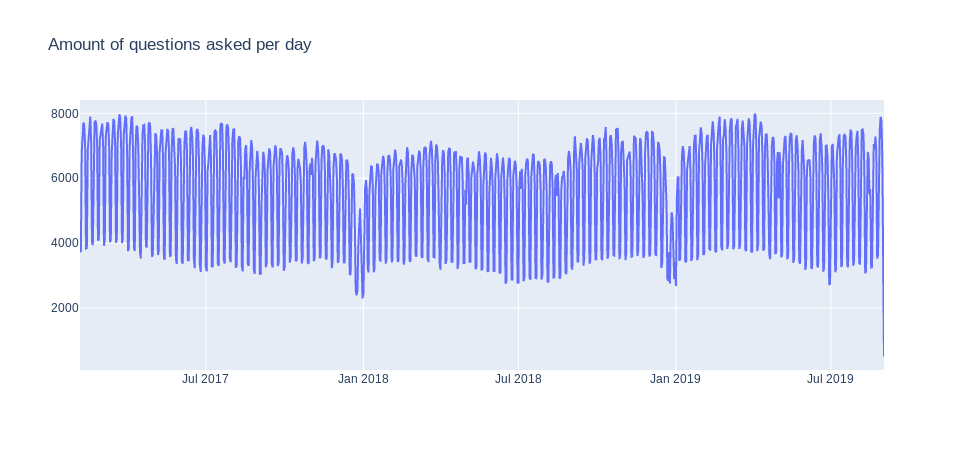

'figures/questions_per_day.html'

In [113]:
import plotly
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=counts_per_day[400:2000].index, y=counts_per_day[400:2000])])
fig.update_layout(title_text="Amount of questions asked per day")
fig.show()
plotly.offline.plot(fig, filename="figures/questions_per_day.html",include_plotlyjs=True, auto_open=False)

In [5]:
questions_df.creation_date[0][:-4]

'2016-01-01 03:06:31.22'

KeyboardInterrupt: 

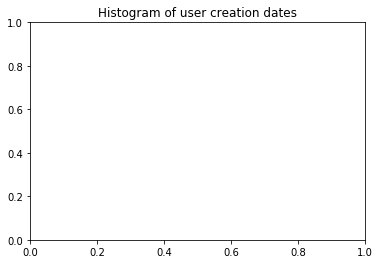

In [25]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure()
plt.title("Histogram of question creation dates")
questions_df["creation_date"].hist()

In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

np.random.seed(1)

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


scatter.on_click(update_point)

f

FigureWidget({
    'data': [{'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
               …